# GHS Model

This notebook runs the code based upon the model in the paper [insert paper name and link if avail here] to allow for quick iteration and exploration. 

## Setup

The following cell performs necessary setup -- imports and function definitions.

In [23]:
import os
import sys
import logging
from abc import ABC, abstractmethod
from typing import SupportsFloat, SupportsInt

os.environ["NUMEXPR_MAX_THREADS"] = "16"
import numpy as np
import pandas as pd

sys.path.append("..")

from modules import util
from modules.models import model_util
from modules.models.model_util import agg_by, trim_max_jobs_per_leaf, get_num_leaves

class Model(ABC):
    def __init__(self, logger=None):
        self.level_one_interp = None
        if logger is None:
            self.logger = logging.getLogger()
        else:
            self.logger = logger

    @abstractmethod
    def get_valid_jobs_per_leaf(self):
        pass

    @abstractmethod
    def get_single_level_predictions(self, num_jobs):
        pass

    @abstractmethod
    def get_job_launch_cost(self, topology, jobs_per_leaf):
        pass

    @abstractmethod
    def get_empty_hierarchy_init_cost(self, topology):
        pass

    def get_interpolated_predictions(self, topology):
        num_levels = len(topology)
        if num_levels not in [1, 2, 3]:
            raise NotImplementedError("{} levels not implemented".format(num_levels))
        elif num_levels == 1 and self.level_one_interp is not None:
            return self.level_one_interp
        prediction_df = self.get_predictions(topology)
        self.logger.debug(
            "Num-Levels: %d, Prediction DF:\n%s", num_levels, prediction_df
        )
        out_df = self.interpolate(
            prediction_df.num_jobs.to_numpy(), prediction_df.makespan.to_numpy()
        )
        out_df["num_levels"] = len(topology)
        if num_levels == 1:
            self.level_one_interp = out_df

        return out_df

    def get_predictions(self, topology):
        num_levels = len(topology)

        jobs_per_leaf = self.get_valid_jobs_per_leaf()
        jobs_per_leaf = jobs_per_leaf.unique()
        assert len(jobs_per_leaf) > 0

        # Case 1: Compute cost for a single scheduler.
        if num_levels == 1:
            num_jobs = jobs_per_leaf
            # Conversion from original model, made March 30, 2022. Adapts to use same functions as
            # multi-level, to ensure that single integers are passed instead of arrays, uniformly.
            #makespans = self.get_single_level_predictions(jobs_per_leaf)
            makespans = [self.get_job_launch_cost([1], jpl) for jpl in jobs_per_leaf]
            self.logger.debug(
                "Num leaves: %d, Num_jobs: %s, Makespans: %s", 1, num_jobs, makespans
            )
        # Case 2: Compute cost for full hierarchy.
        else:
            num_leaves = get_num_leaves(topology)
            # Recall that jobs_per_leaf is a progressive array, so this just handles distribution.
            num_jobs = np.array([jpl * num_leaves for jpl in jobs_per_leaf])
            self.logger.debug(
                "Num leaves: %d, Num_jobs: %s, Jobsperleaf: %s",
                num_leaves,
                num_jobs,
                jobs_per_leaf,
            )
            # This is where the callstack starts for proper computation.
            makespans = self.get_multilevel_predictions(topology, jobs_per_leaf)
        out_df = pd.DataFrame(data={"num_jobs": num_jobs, "makespan": makespans})
        out_df["num_levels"] = len(topology)
        out_df.sort_values(by="num_jobs")
        return out_df

   
    def get_multilevel_predictions(self, topology, jobs_per_leaf: np.ndarray):
        if len(topology) < 2:
            raise ValueError("Must be passed a multi-level topology")
        # Cost calculation contains the equations from the paper.
        return [self.calc_cost(topology, jpl) for jpl in jobs_per_leaf]

    @staticmethod
    def interpolate(num_jobs, makespans):
        interp_num_jobs, interp_makespans = interpolate_real_data(
            num_jobs, makespans, degree=2
        )
        return pd.DataFrame(
            data={
                "num_jobs": interp_num_jobs,
                "makespan": interp_makespans,
                "throughput": interp_num_jobs / interp_makespans,
            }
        )

    def calc_cost(self, topology, jobs_per_leaf: np.int32):
        # Correlates to Create(Tree)
        cost_to_launch_hierarchy = self.get_empty_hierarchy_init_cost(topology)
        # Only have to consider the cost at the last leaf (it is the straggler/on the critical path)
        # Equation 1 in paper
        cost_to_launch_jobs = self.get_job_launch_cost(topology, jobs_per_leaf)
        # Equation 6 in paper
        total_cost = cost_to_launch_hierarchy + cost_to_launch_jobs
        self.logger.log(
            9,
            "Level-{}, jobsperleaf: {:4d}, hierarchy_launch: {:4.1f}, job_launch: {:7.1f}, total: {:7.1f}".format(
                len(topology),
                jobs_per_leaf,
                cost_to_launch_hierarchy,
                cost_to_launch_jobs,
                total_cost,
            ),
        )
        return total_cost

    @abstractmethod
    def calc_model_cost(self):
        pass
    


class AnalyticalModel(Model):
    def __init__(
        self,
        sched_rate: SupportsFloat,
        sched_create_cost: SupportsFloat,
        resource_cap: SupportsFloat,
        max_jobs_per_leaf: SupportsInt,
        logger=None,
    ):
        """
        sched_rate is the maximum throughput, in jobs per second, that a given
        scheduler implementation can achieve on a resource unconstrained system.
        resource_cap is the maximum number of jobs that can be running
        simultaneously due to resource capacity constraints
        """
        super().__init__(logger=logger)
        self.sched_rate = float(sched_rate)
        self.sched_create_cost = float(sched_create_cost)
        self.resource_cap = float(resource_cap)
        self.max_jobs_per_leaf = int(max_jobs_per_leaf)

    @abstractmethod
    def get_single_level_predictions(self, num_jobs: np.ndarray, resource_cap=None, runtime=None):
        pass

    @abstractmethod
    def calc_model_cost(self):
        pass

    def get_valid_jobs_per_leaf(self):
        return pd.Series(data=np.arange(1, self.max_jobs_per_leaf + 1, dtype=np.int32))

    def get_interpolated_predictions(self, topology):
        # No need for interpolation with this inexpensive analytical model
        pred_df = self.get_predictions(topology)
        pred_df["throughput"] = pred_df.num_jobs / pred_df.makespan
        return pred_df

    # Works towards filling out equation 1 from paper
    def get_job_launch_cost(self, topology, jobs_per_leaf: pd.Series):
        num_leaves = get_num_leaves(topology)
        return self.get_single_level_predictions(
            np.array([jobs_per_leaf]), resource_cap=self.resource_cap / num_leaves
        )[0]

     # Finds the cost for tree creation.
     # Equation 3 in paper
    def get_empty_hierarchy_init_cost(self, topology):
        if len(topology) == 0:
            return 0
        return self.get_single_level_predictions(np.array([topology[-1]]), runtime=0)[
            0
        ] + self.get_empty_hierarchy_init_cost(topology[:-1])
    
class AnalyticalModelContentedRuntime(AnalyticalModel):
    def __init__(
        self,
        sched_rate: SupportsFloat,
        sched_create_cost: SupportsFloat,
        resource_cap: SupportsFloat,
        avg_runtime_func,
        cores_per_node,
        max_jobs_per_leaf=1024,
        logger=None,
    ):
        """
        sched_rate is the maximum throughput, in jobs per second, that a given
        scheduler implementation can achieve on a resource unconstrained system.
        resource_cap is the maximum number of jobs that can be running
        simultaneously due to resource capacity constraints
        """
        super().__init__(sched_rate, sched_create_cost, resource_cap, max_jobs_per_leaf, logger=logger)

        self.get_avg_runtime = avg_runtime_func
        self.cores_per_node = cores_per_node

    # Calculates equation 1 in paper.
    def get_single_level_predictions(self, num_jobs: np.ndarray, resource_cap=None, runtime=None):
        print(num_jobs)
        if resource_cap is None:
            resource_cap = self.resource_cap  # assume we are using the whole system
        if runtime is None:
            runtime = self.get_avg_runtime(num_jobs, resource_cap)
        sched_bottleneck = num_jobs / self.sched_rate
        resource_bottleneck = (
            num_jobs * runtime
        ) / num_jobs.clip(
            max=resource_cap
        )  # clip(max=X) sets all values greater than X to X.  equivalent to .apply(lambda x: min(x, X))
        true_bottleneck = np.maximum(sched_bottleneck, resource_bottleneck)
        init_cost = self.sched_create_cost
        return true_bottleneck + init_cost

    def calc_model_cost(self):
        num_waves = 3
        contention_test = (
            self.get_avg_runtime(self.cores_per_node * num_waves, self.cores_per_node)
            * num_waves
        )
        return (contention_test, contention_test)

In [24]:
from __future__ import print_function

import os
import argparse
import logging
import functools
import itertools
import multiprocessing as mp
import sys

os.environ["NUMEXPR_MAX_THREADS"] = "16"
import numpy as np
import pandas as pd




def create_model(unique_id):
    return AnalyticalModelContentedRuntime(
        sched_rate=sched_rate,
        sched_create_cost=sched_create_cost,
        resource_cap=total_cores,
        avg_runtime_func=functools.partial(model_util.get_avg_runtime, unique_id, system="lassen"),
        cores_per_node=cores_per_node,
        max_jobs_per_leaf=32768,
        logger=logger,
    )

def gen_df(topology, unique_id):
    analyticalWithContention_model = create_model(unique_id)
    df = analyticalWithContention_model.get_interpolated_predictions(topology)
    df["unique_id"] = unique_id
    df["topology"] = "x".join([str(x) for x in topology])
    df["throughput_upperbound"] = df["num_jobs"].apply(
        lambda x: model_util.calc_upperbound(unique_id, x, total_cores)
    )
    return df


def parallel_gen_df(tupl):
    return gen_df(*tupl)





## Running Model

The following cell runs the model, currently requires user-editing of values. Will switch to ipywidget.

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("model_scale_study")

num_nodes = 4500
global cores_per_node
cores_per_node = 44
global total_cores
total_cores = num_nodes * cores_per_node
global sched_rate
sched_rate = 3.6
global sched_create_cost
sched_create_cost = 3.4

topologies = [
    [1],
    [1, 32],
    #[1, num_nodes],
    [1, 32, 36],
    #[1, 444, 444],
    [1, num_nodes, cores_per_node],
    [1, 55, 60, 60],
]
unique_ids = ["sleep0"]
func_args = itertools.product(topologies, unique_ids)
with mp.Pool() as pool:
    dfs = pool.map(parallel_gen_df, func_args)

model = create_model("sleep0")
for topology in topologies:
    create_time = model.get_empty_hierarchy_init_cost(topology)
    logger.info("Topology %s is predicted to take %f seconds to create", topology, create_time)

new_model_df = pd.concat(dfs, sort=True)
new_model_df["model_type"] = "analyticalWithContention"
util.pretty_log_df(new_model_df, "Final DataFrame", logger)

#logger.info("Saving data to {}".format("new_shape.pkl"))
#new_model_df.to_pickle("new_shape.pkl")



[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[44]
[31]
[4500]
[32]
[1]
[33]
[1]
[34]
[44]
[35]
[4500]
[36]
[1]
[37]
[2]
[38]
[44]
[39]
[4500]
[40]
[1]
[41]
[3]
[42]
[44]
[43]
[4500]
[44]
[1]
[45]
[4]
[46]
[44]
[47]
[60]
[4500]
[48]
[1]
[60]
[49]
[5]
[50]
[55]
[44]
[51]
[1]
[4500]
[52]
[1]
[1]
[53]
[6]
[54]
[60]
[44]
[55]
[4500]
[60]
[56]
[36]
[1]
[57]
[55]
[32]
[7]
[32]
[58]
[1]
[44]
[1]
[1]
[59]
[2]
[4500]
[1]
[60]
[1]
[1]
[60]
[61]
[32]
[8]
[36]
[60]
[62]
[1]
[44]
[32]
[55]
[63]
[2]
[4500]
[1]
[1]
[64]
[1]
[32]
[2]
[3]
[65]
[9]
[1]
[60]
[66]
[36]
[44]
[3]
[60]
[67]
[32]
[4500]
[32]
[55]
[68]
[1]
[1]
[1]
[69]
[1]
[3]
[10]
[4]
[70]
[4]
[36]
[44]
[32]
[71]
[60]
[4500]
[32]
[1]
[72]
[60]
[1]
[1]
[5]
[73]
[55]
[11]
[4]
[32]
[74]
[1]
[44]
[1]
[36]
[75]
[5]
[4500]
[6]
[32]
[76]
[60]
[1]
[32]
[1]
[77]
[60]
[1]
[12]
[78]
[5]
[55]
[7]
[44]
[79]
[36]
[32]
[1]
[4500]
[80]
[32]
[1]
[6]
[81]
[1]
[1]
[8]

[60]
[1]
[32]
[32]
[381]
[60]
[83]
[1]
[1]
[382]
[55]
[44]
[76]
[100]
[383]
[1]
[4500]
[36]
[32]
[384]
[1]
[64]
[32]
[1]
[385]
[84]
[60]
[1]
[101]
[386]
[44]
[60]
[77]
[32]
[387]
[4500]
[55]
[36]
[1]
[1]
[388]
[1]
[32]
[102]
[85]
[389]
[65]
[1]
[44]
[32]
[60]
[390]
[78]
[4500]
[1]
[60]
[391]
[36]
[1]
[103]
[55]
[392]
[86]
[32]
[32]
[1]
[393]
[44]
[1]
[66]
[1]
[394]
[4500]
[79]
[60]
[104]
[395]
[1]
[36]
[60]
[32]
[87]
[396]
[32]
[55]
[1]
[44]
[397]
[1]
[1]
[105]
[4500]
[398]
[67]
[80]
[1]
[32]
[399]
[60]
[36]
[88]
[1]
[400]
[60]
[32]
[44]
[106]
[55]
[401]
[1]
[4500]
[32]
[1]
[402]
[1]
[81]
[1]
[68]
[403]
[89]
[36]
[60]
[107]
[404]
[44]
[32]
[60]
[32]
[4500]
[405]
[1]
[55]
[1]
[1]
[406]
[1]
[82]
[108]
[90]
[407]
[69]
[36]
[32]
[44]
[60]
[408]
[32]
[4500]
[1]
[60]
[409]
[1]
[1]
[109]
[55]
[410]
[83]
[91]
[32]
[1]
[411]
[36]
[44]
[1]
[70]
[412]
[32]
[4500]
[110]
[60]
[413]
[1]
[1]
[60]
[32]
[414]
[92]
[84]
[55]
[1]
[415]
[44]
[36]
[1]
[111]
[4500]
[416]
[71]
[32]
[32]
[1]
[417]
[60]
[1]
[1

## Plotting Model - Setup

The following cell performs necessary imports and function definitions to plot model output.

In [21]:
from __future__ import print_function

import re
import os
import json
import math
import argparse
import itertools
import logging
from datetime import timedelta

import matplotlib

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import six.moves

from modules import util


def add_suffix_to_label(label, base=2):
    if base == 2:
        divisor = 1024
    elif base == 10:
        divisor = 1000
    else:
        raise NotImplementedError()

    if label < 1000:
        return label
    elif label < 1_000_000:
        return "{:d}K".format(int(label // divisor))
    elif label < 1_000_000_000:
        return "{:d}M".format(int(label // math.pow(divisor, 2)))
    elif label < 1_000_000_000_000:
        return "{:d}B".format(int(label // math.pow(divisor, 3)))
    else:
        raise NotImplementedError()


def setup_fig(fig, ax, no_yaxis=False):
    global YLIM
    ax.set_xscale("log", basex=2)
    ax.set_yscale("log")
    xtick_locs = [int(math.pow(4, x)) for x in range(0, 18)]
    plt.xticks(
        xtick_locs,
        [add_suffix_to_label(tick) for tick in xtick_locs],
        rotation="vertical",
        fontsize=TEXTSIZE,
    )
    ytick_locs = [0] + [int(math.pow(10, x)) for x in range(0, 7)]
    plt.yticks(
        ytick_locs,
        [add_suffix_to_label(tick, 10) for tick in ytick_locs],
        rotation="horizontal",
        fontsize=TEXTSIZE,
    )

    #ax.set_xlim(0.8, 1048576 * 1.2)
    ax.set_xlim(0.8, 4500 * 44 * 32768 * 1.4)
    ax.set_ylim(0.1, YLIM)
    ax.grid(axis="y", which="major", color="black")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    locmin = matplotlib.ticker.LogLocator(
        base=10.0, subs=np.arange(2, 10) * 0.1, numticks=40
    )
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.set_xlabel("Number of jobs (total)", fontweight="bold", fontsize=AXIS_LABELSIZE)
    ax.set_ylabel(
        "Avg. Throughput (jobs/sec)", fontweight="bold", fontsize=AXIS_LABELSIZE
    )
    ax.tick_params(axis="y", which="minor", left=True, top=True)

def log_range(range_min, range_max, base=2):
    return itertools.takewhile(
        lambda x: x <= range_max,
        [
            math.pow(base, x)
            for x in six.moves.range(
                int(math.floor(math.log(range_min, base))),
                int(math.ceil(math.log(range_max, base)) + 1),
            )
        ],
    )


def plot_model(model_df, ax, unique_id):
    legend_handles = []
    model_df = model_df.sort_values(by=["num_jobs"])
    label = "throughput"

    level_color_map = {
        1: "red",
        2: "blue",
        3: "green",
        4: "orange",
    }
    # for level, color_char, line_label in [
    #     (1, "r", "1-Level"),
    #     (2, "b", "2-Level"),
    #     (3, "g", "3-Level"),
    # ]:
    def get_num_levels(topology):
        return len(topology.split('x'))

    def get_topology_order(topology):
        topo = [int(x) for x in topology.split('x')]
        num_levels = len(topo)
        if num_levels == 1:
            return (1, 1)
        if topo[1] == 32:
            return (1, num_levels)
        return (2, num_levels)

    for topology in sorted(model_df['topology'].unique(), key=get_topology_order):
        level_df = model_df[model_df.topology == topology]
        num_levels = get_num_levels(topology)
        if num_levels == 1 or int(topology.split('x')[1]) == 32:
            linestyle = "--"
        else:
            linestyle = ":"
        color = level_color_map[num_levels]
        Xs = level_df["num_jobs"]
        Ys = level_df[label]
        line_2d = ax.plot(Xs, Ys, color=color, linestyle=linestyle, label=topology)
        assert len(line_2d) == 1
        legend_handles.append(line_2d.pop())


    return legend_handles

## Plotting Model - Run

The following cell runs plotting code for the model. Note that it does not currently take into account experimental data.

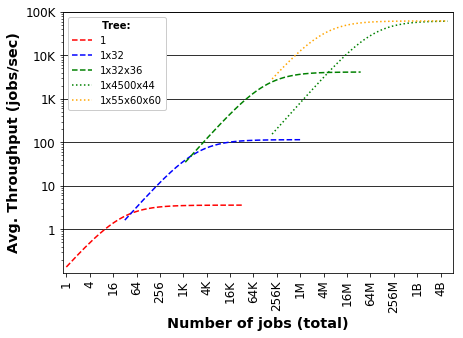

In [12]:
%matplotlib inline

LINEWIDTH = 3
MARKERSIZE = 10
TEXTSIZE = "large"
LEGEND_TEXTSIZE = "medium"
AXIS_LABELSIZE = "x-large"
FIG_HEIGHT = 4.8
FIG_WIDTH = 7
YLIM = 100000

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("plot_model_scale_study")

scale_up_df = pd.read_pickle("new_shape.pkl")
assert len(scale_up_df) > 0

for idx, unique_id in enumerate(scale_up_df['unique_id'].unique()):
    app_model_df = scale_up_df[scale_up_df.unique_id == unique_id]

    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    setup_fig(fig, ax, no_yaxis=(idx > 0))

    legend_handles = plot_model(app_model_df, ax, unique_id)

    loc = "upper left"
    legend = plt.legend(
        handles=legend_handles,
        loc=loc,
        title="Tree:",
        frameon=True,
        framealpha=1,
        title_fontsize=LEGEND_TEXTSIZE,
        prop={"size": LEGEND_TEXTSIZE},
    )
    legend.get_title().set_weight("bold")

    #if args.nofig:
    #    pass
    #elif args.savefig is not None:
    #    plt.tight_layout()
    #    filename = "{0}_scale_up.pdf".format(unique_id)
    #    logger.info("Saving to %s", filename)
    #    plt.savefig(filename, bbox_inches="tight")
    #else:
    plt.show()